## libraries

In [115]:
import pandas as pd
import numpy as np
import glob
import os
import sys

from tqdm import tqdm
from joblib import dump, load 

import matplotlib.pyplot as plt

from ctgan import CTGAN
from table_evaluator import load_data, TableEvaluator

In [118]:
import warnings
warnings.filterwarnings("ignore")

## data

In [23]:
X_tr_list = sorted(glob.glob('../data/train_input/*.csv'))
X_te_list = sorted(glob.glob('../data/test_input/*.csv'))
y_tr_list = sorted(glob.glob('../data/train_target/*.csv'))
y_te_list = sorted(glob.glob('../data/test_target/*.csv'))
print('train :', len(X_tr_list), len(y_tr_list))
print('test  :', len(X_te_list), len(y_te_list))

train : 28 28
test  : 5 5


## preprocessing

In [86]:
def ctgan_preprocessing(df_list):

    for df_path in df_list:

        # return df
        df_fin = pd.DataFrame()
        
        # input df
        df = pd.read_csv(df_path)
        df['obs_time'] = df.index % 24 
        df = abs(df)
        
        # data range
        df.loc[(df['내부온도관측치'] > 40), '내부온도관측치'] = 40
        df.loc[(df['내부습도관측치'] > 100), '내부습도관측치'] = 100
        df.loc[(df['co2관측치'] > 1200), 'co2관측치'] = 1200
        df.loc[(df['ec관측치'] > 8), 'ec관측치'] = 8
        df.loc[(df['시간당분무량'] > 3000), '시간당분무량'] = 3000
        df.loc[(df['시간당백색광량'] > 120000), '시간당백색광량'] = 120000
        df.loc[(df['시간당적색광량'] > 120000), '시간당적색광량'] = 120000
        df.loc[(df['시간당청색광량'] > 120000), '시간당청색광량'] = 120000
        df.loc[(df['시간당총광량'] > 120000), '시간당총광량'] = 120000
        df['시간당총광량'] = df['시간당청색광량'] + df['시간당백색광량'] + df['시간당적색광량']
        
        cols = df.columns

        for i in range(0, len(cols)):
            col = cols[i]

            if '누적' in col:
                df[col] = df.groupby((df.obs_time == 0).cumsum()).agg(cols[i - 1]).cumsum()

            df_fin = pd.concat([df_fin, df])

    return df_fin

In [90]:
X_tr = ctgan_preprocessing(X_tr_list)
X_tr

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,29.775000,59.368334,515.650000,0.974514,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,0,1,29.538983,58.177966,516.050848,0.973802,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,0,2,29.613334,58.790000,520.516667,0.975808,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,0,3,29.431666,59.031667,522.266667,0.977754,769.0,769.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,0,4,29.608334,59.286667,521.983333,0.986603,0.0,769.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


## train

In [100]:
# category cols
discrete_cols = ['obs_time']

# ctgan
model = CTGAN(verbose=True)
model.fit(X_tr, discrete_cols, epochs=200)

Epoch 1, Loss G:  2.9448,Loss D: -0.6845
Epoch 2, Loss G:  1.7743,Loss D:  0.2869
Epoch 3, Loss G:  2.0693,Loss D:  0.2769
Epoch 4, Loss G:  2.2874,Loss D:  0.1782
Epoch 5, Loss G:  2.2333,Loss D:  0.0577
Epoch 6, Loss G:  2.1191,Loss D: -0.1162
Epoch 7, Loss G:  1.4620,Loss D:  0.2514
Epoch 8, Loss G:  0.9517,Loss D:  0.3699
Epoch 9, Loss G:  1.0433,Loss D:  0.1784
Epoch 10, Loss G:  1.0070,Loss D:  0.0201
Epoch 11, Loss G:  0.7770,Loss D: -0.1254
Epoch 12, Loss G:  0.4480,Loss D:  0.0177
Epoch 13, Loss G: -0.1462,Loss D:  0.0578
Epoch 14, Loss G: -0.2041,Loss D: -0.1708
Epoch 15, Loss G: -0.6501,Loss D:  0.0288
Epoch 16, Loss G: -0.7824,Loss D:  0.0011
Epoch 17, Loss G: -1.0438,Loss D:  0.2411
Epoch 18, Loss G: -1.1036,Loss D:  0.0589
Epoch 19, Loss G: -1.0453,Loss D: -0.2941
Epoch 20, Loss G: -1.1227,Loss D:  0.0056
Epoch 21, Loss G: -1.1649,Loss D: -0.1499
Epoch 22, Loss G: -1.0508,Loss D: -0.0162
Epoch 23, Loss G: -0.7975,Loss D: -0.0279
Epoch 24, Loss G: -1.2762,Loss D: -0.0934
E

C:\Users\반소희\AppData\Roaming\Python\Python38\site-packages\ctgan\data_transformer.py:188: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1] = np.argmax(column_data[:, 1:], axis=1)
C:\Users\반소희\AppData\Roaming\Python\Python38\site-packages\ctgan\data_transformer.py:188: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1] = np.argmax(column_data[:, 1:], axis=1)
C:\Users\반소희\AppData\Roaming\Python\Python38\site-packages\ctgan\data_transformer.py:188: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set 

In [107]:
# save model
dump(model, '../result/ctgan')

['../result/ctgan']

In [108]:
# load model
load_model = load('../result/ctgan')

## eval

In [110]:
# generate samples based on learned model
aug_samples = model.sample(1000)

# result of sorted samples
aug_samples.sort_values(by=['DAT', 'obs_time'], ascending=[True, True], inplace=True)
aug_samples.head(2)

C:\Users\반소희\AppData\Roaming\Python\Python38\site-packages\ctgan\data_transformer.py:188: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1] = np.argmax(column_data[:, 1:], axis=1)
C:\Users\반소희\AppData\Roaming\Python\Python38\site-packages\ctgan\data_transformer.py:188: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1] = np.argmax(column_data[:, 1:], axis=1)
C:\Users\반소희\AppData\Roaming\Python\Python38\site-packages\ctgan\data_transformer.py:188: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set 

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
714,0,1,30.088215,59.694229,547.445078,1.041387,-0.294340,6983.979851,-20.063753,956.424183,-2.306983,-21.371034,-2.776665,-1.061631,26.309772,1844.251622
772,0,1,32.250711,58.154720,435.938355,0.996336,766.330917,6693.780386,25.063556,105.579046,-0.023841,48.195777,1.252605,-38.926344,-17.778811,206480.744467


In [112]:
# check data shape
X_tr.shape, aug_samples.shape

((10752, 16), (1000, 16))

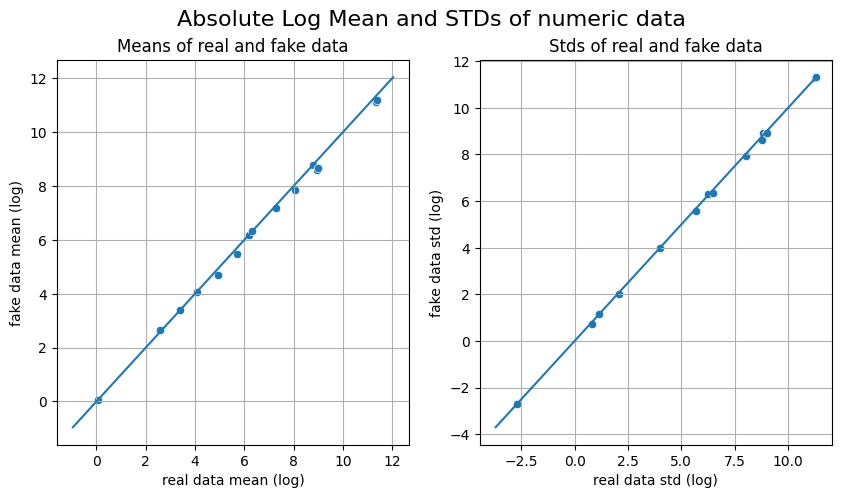

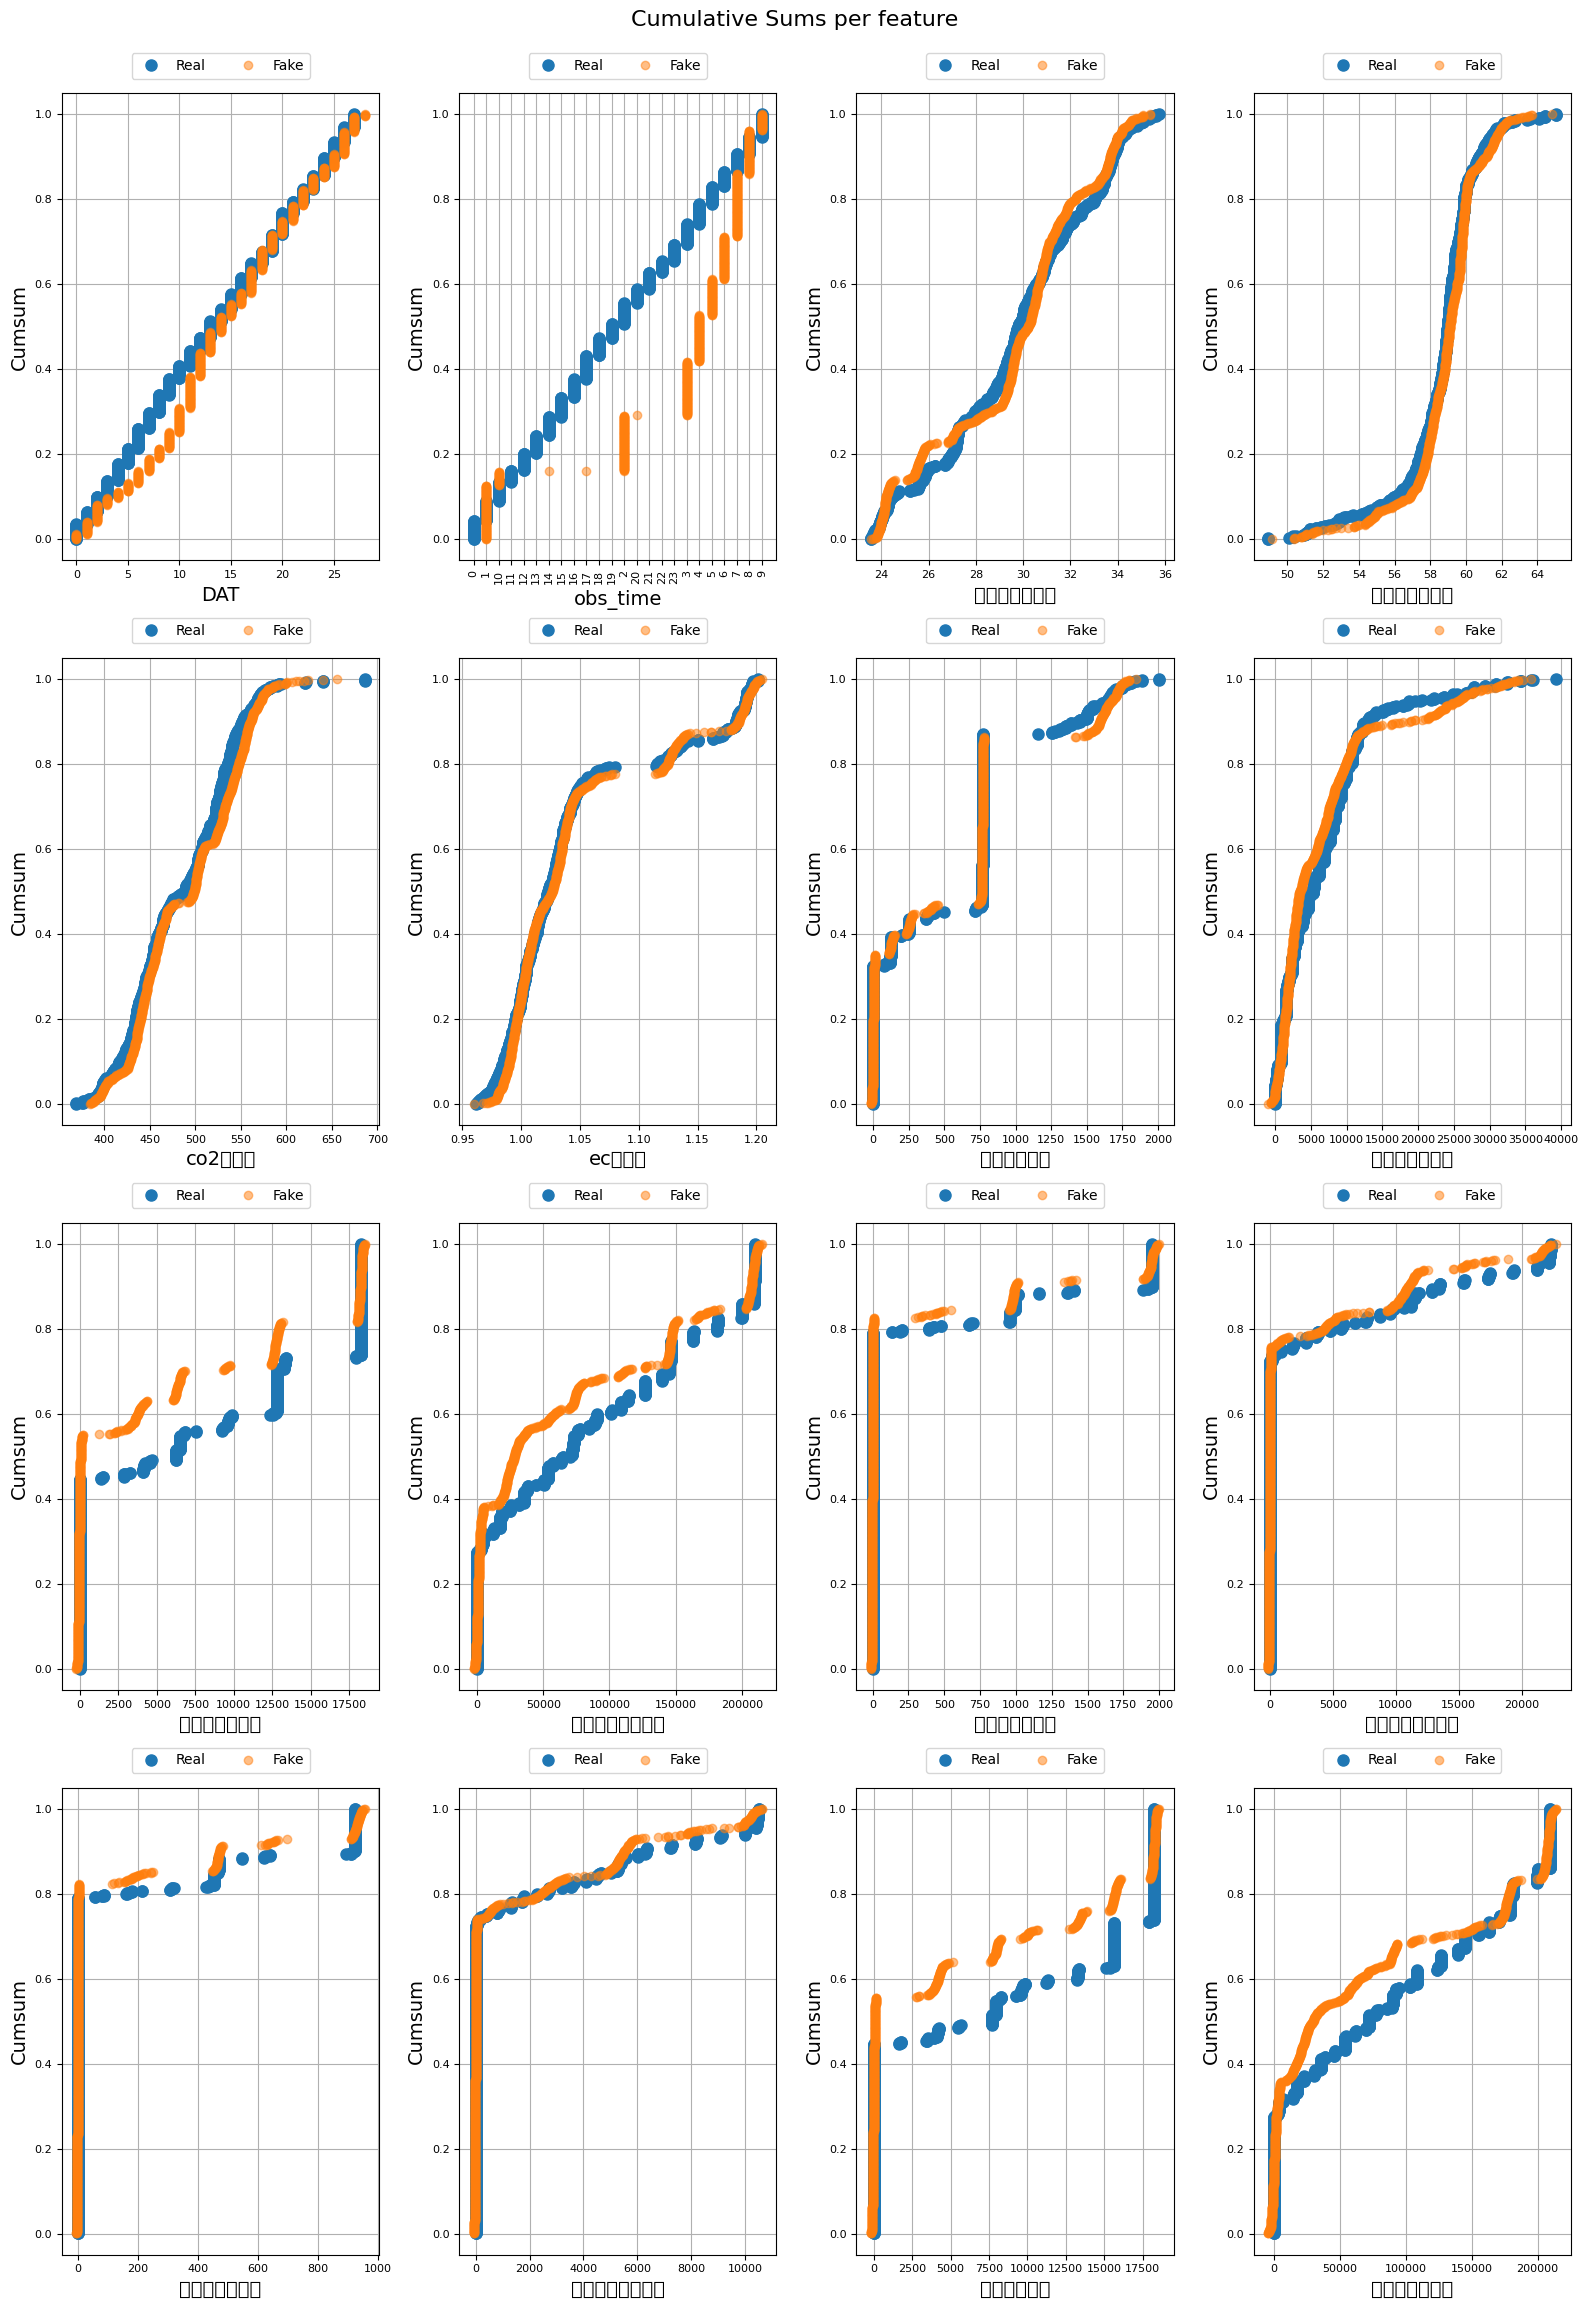

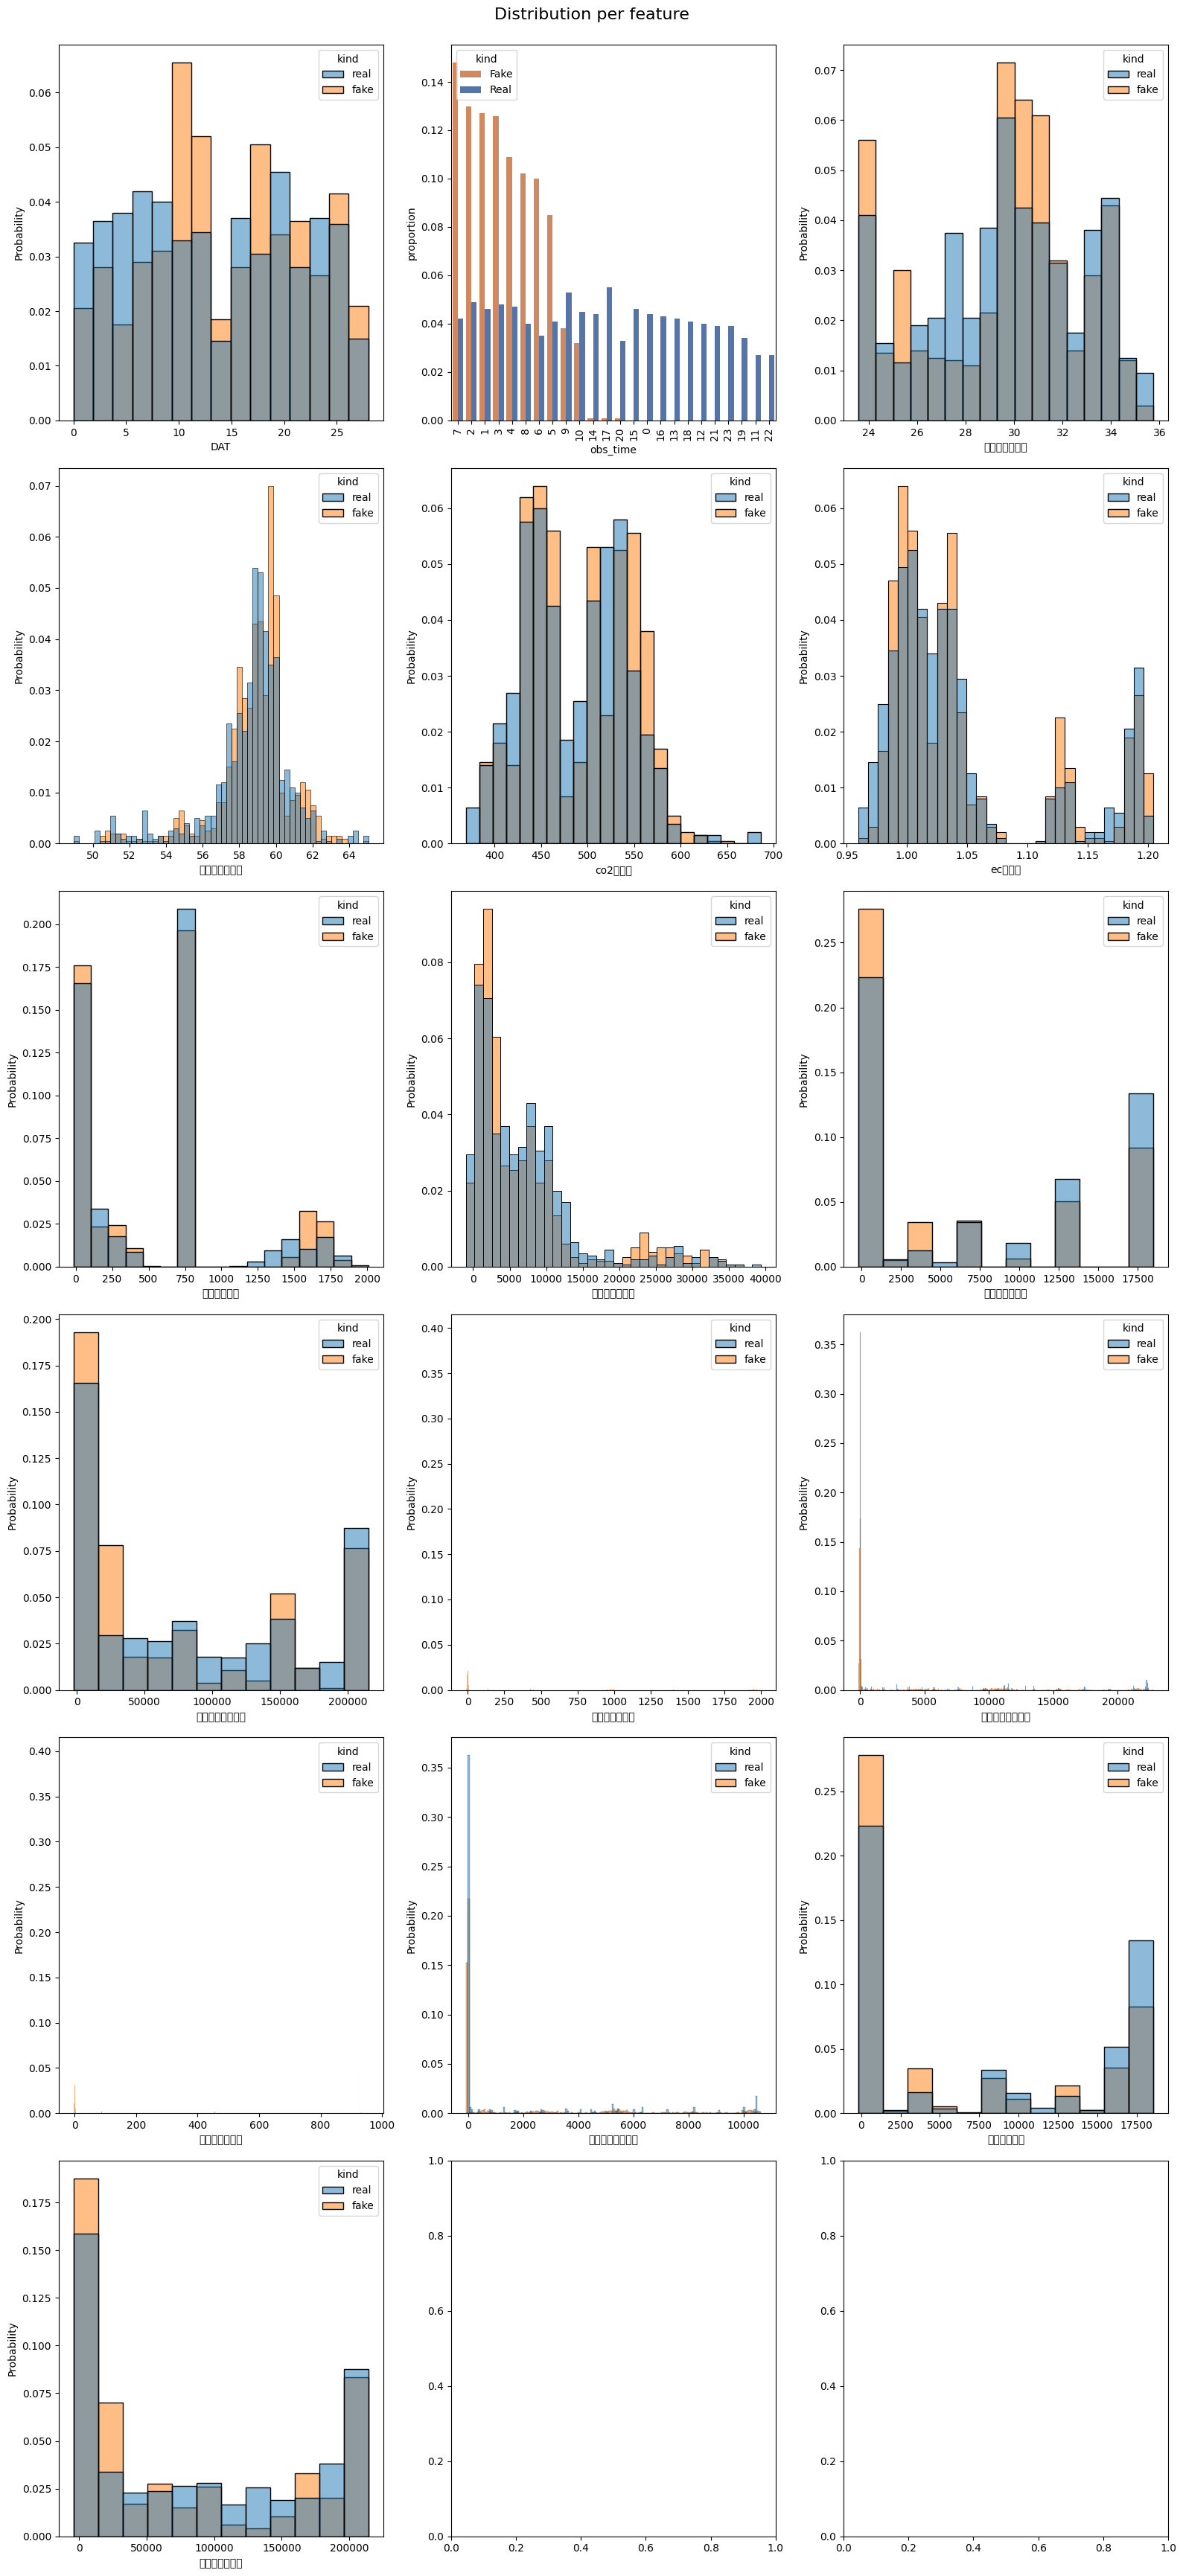

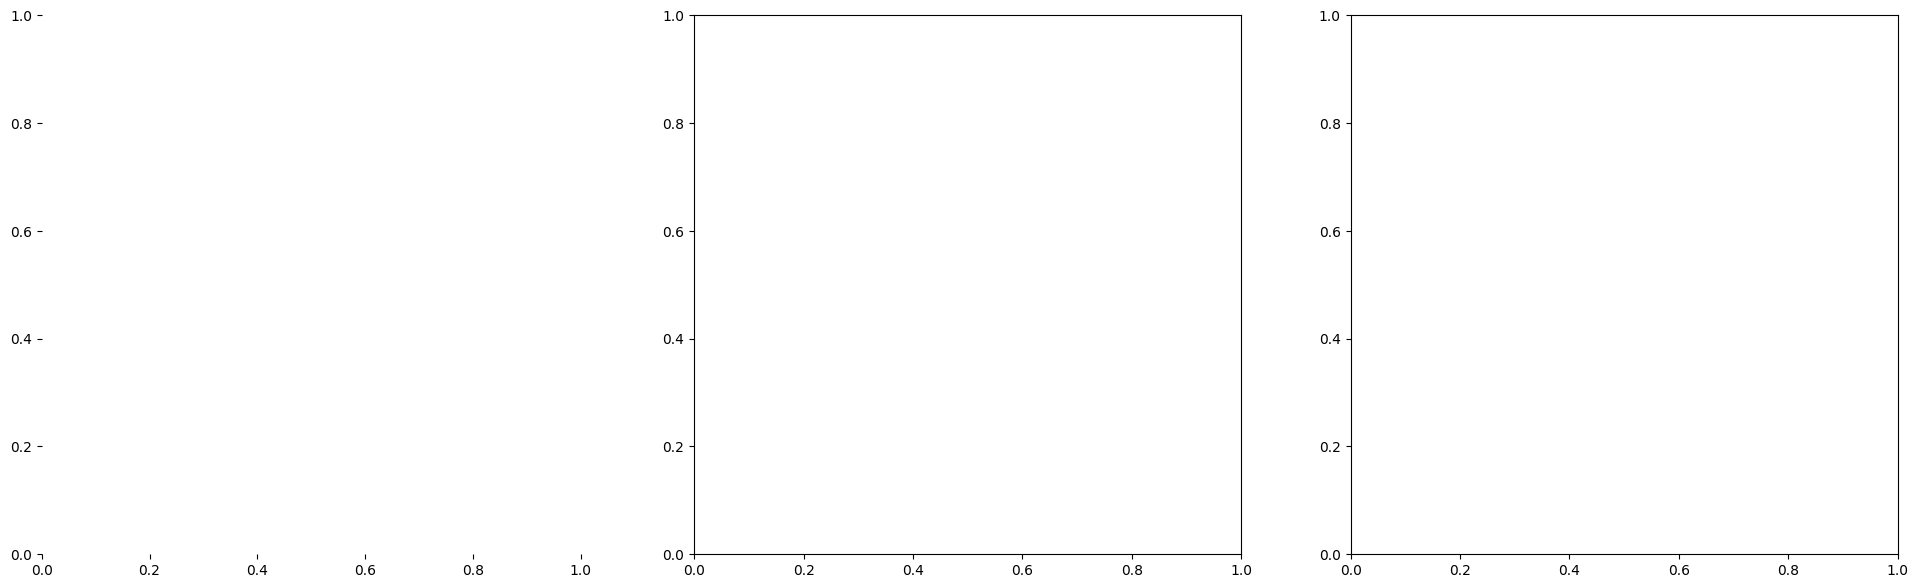

In [122]:
table_evaluator = TableEvaluator(X_tr, aug_samples, cat_cols=discrete_cols)
try:
    table_evaluator.visual_evaluation()
except:
    pass